# Assignment 5: Regularized models

### Instructions

* Write your code in the cells provided.  Where appropirate, enter markdown to answer questions.
* Delete your output before submitting and ensure that the code works when executed sequentially
* Submit this notebook to OWL.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import sklearn as sk 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
pd.set_option('display.max_columns', 500)

%matplotlib inline

# You're Still a Data Scientist!

Your models from the last assignment really impressed some in the management in your football club. Now that you have learned the art of regularization, your boss thinks you should do equally well with much less data. This will safe a lot of money the next time around. This time you get only a data set with 3000 observations.

### Question1: Preprocessing (1pt)

To get started repeat the preprocessing steps from last time: 
* Drop the variables: 'ID','club','club_logo','flag', 'nationality','photo','potential', 'birth_date'
* Dummy code the variables: work_rate_att, work_rate_def, preferred_foot. **Because we are running a regularized model, we do not want to drop the first column**
* Get a test data set of size 500 - to make results comparable to solutions, set random_state = 0

To make sure that you get a good start - check the solutions from Assignment 4. And make sure you can apply these steps flexibly and quickly. **You will need it for the midterm!**

In [2]:
df = pd.read_csv('footballer_small.csv').iloc[:,1:]

# Drop the aformentioned columns
model_data = df.drop(['ID','club','club_logo','flag', 'nationality','photo','potential', 'birth_date'], axis = 'columns')

# In order to get dummies, convert categorical data to categorical type
model_data['work_rate_att'] = pd.Categorical(model_data.work_rate_att, categories=['Low','Medium','High'])
model_data['work_rate_def'] = pd.Categorical(model_data.work_rate_def, categories=['Low','Medium','High'])
model_data['preferred_foot'] = pd.Categorical(model_data.preferred_foot, categories = ['Left','Right'])

# Dummies, dropping the first category
model_data = pd.get_dummies(model_data, drop_first=False)

y = model_data.overall
X = model_data.drop('overall', axis = 'columns')

# Random state assures that folds are consistent across models
Xtrain, Xtest, ytrain, ytest = train_test_split(X,
                                                y, 
                                                test_size = 500, 
                                                random_state = 0)
print('Training set size:',Xtrain.shape)



Training set size: (2500, 48)


### Question 2: Build a pipeline to preprocess the data (2pt)

To run the regression model, we want to have a design matrix which houses standardized features (that is, subtracts their means and divides by their standard deviations) and no intercept.  

The Senior Data Scientist has asked you to build a pipeline to perform these actions. In your model pipeline, set ride regression's penalization parameter to 0.5. Do so and then visualize the first 50 rows of your design matrix using `matplotlib.pyplot.imshow`.

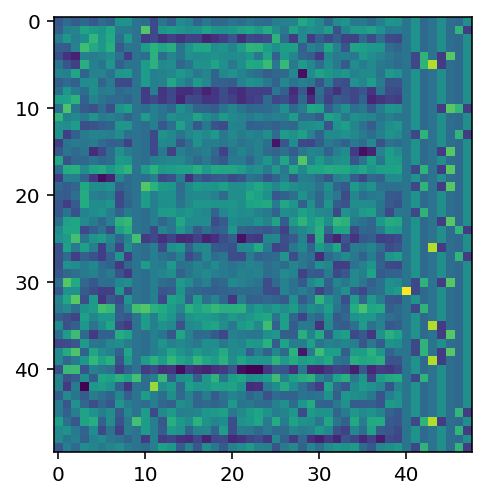

In [3]:
# There are two ways to solve this assignment:
# Using pipelines and performing the computations more or less manually
# For didactic purposes, we will show you both

scaler = StandardScaler()

transformed_X = scaler.fit_transform(Xtrain)

plt.imshow(transformed_X[:50,])

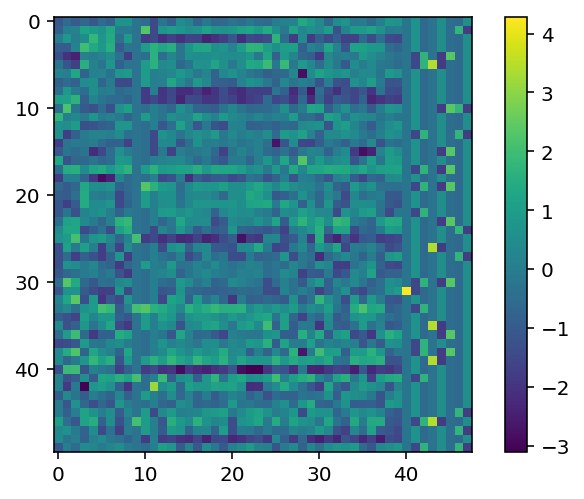

In [4]:
#Buid a pipeline to scale and then fit a Ridge regression
model_pipeline = Pipeline([
    ('standardize', StandardScaler()),
    ('reg', Ridge(alpha=0.5, fit_intercept=True) )
])


standardizer_step = model_pipeline.named_steps['standardize']
transformed_X = standardizer_step.fit_transform(Xtrain)

plt.imshow(transformed_X[:50])
plt.colorbar()

### Question 3: Do ridge regression (2pt)
Now use Ridge regression with a ridge parameter of 0.5 and report the Validation error on the training set. Use 10-fold cross-validation.  

In [5]:
#Manually
ridge = Ridge(alpha=0.5)
cv_scores = cross_val_score(ridge, 
                            transformed_X, 
                            ytrain,
                            cv=10,
                            scoring='neg_mean_squared_error')
meancv=-cv_scores.mean()

print(meancv) 

5.914575436682226


In [6]:
#With Pipelines
cv_scores = cross_val_score(model_pipeline, 
                            Xtrain, 
                            ytrain ,
                            cv=10,
                            scoring='neg_mean_squared_error')
meancv=-cv_scores.mean()

print(meancv) 

5.914575367646265


### Question 4: Test Error (3pt)
Now test how the ridge model, fitted to the whole training set, on how it performs on the Test data set. Because you wrote a pipeline to perform the preprocessing steps, you shouldn't have to worry about preprocessing the test data.


Report the mean squared error on the test data - along with the 95% confidencen interval, determined with the central limit theorem. What proportion of the variance in the test scores have you predicted (+ CI)? 

In [7]:
#Manually

ridge.fit(transformed_X, ytrain)

transformed_test_X = scaler.transform(Xtest)
ypred = ridge.predict(transformed_test_X)

sqerr = (ytest-ypred)**2 
test_error = sqerr.mean() 
test_ci = test_error + 1.96 * np.std(sqerr) / np.sqrt(len(sqerr)) * np.array([-1, 1])

print("Mean test error: ",test_error)
print("95% CI: ",test_ci)

ss = (ytest-ytest.mean())**2 
print("Proportion variance predicted: ",1-test_error/ss.mean())
print("95% CI: ",1-test_ci/ss.mean())


Mean test error:  6.451153177980513
95% CI:  [5.55134368 7.35096268]
Proportion variance predicted:  0.8748311749551935
95% CI:  [0.89228977 0.85737258]


In [8]:
model_pipeline.fit(Xtrain, ytrain)

ypred = model_pipeline.predict(Xtest)

sqerr = (ytest-ypred)**2 
test_error = sqerr.mean() 
test_ci = test_error + 1.96 * np.std(sqerr) / np.sqrt(len(sqerr)) * np.array([-1, 1])

print("Mean test error: ",test_error)
print("95% CI: ",test_ci)

ss = (ytest-ytest.mean())**2 
print("Proportion variance predicted: ",1-test_error/ss.mean())
print("95% CI: ",1-test_ci/ss.mean())


Mean test error:  6.451153177980513
95% CI:  [5.55134368 7.35096268]
Proportion variance predicted:  0.8748311749551935
95% CI:  [0.89228977 0.85737258]


### Question 5: Tune the ridge parameter (3pt)
Now use 10-fold CV on the training set to determine a good setting for the regularization coefficient. Perform the search in log-space, going from $\lambda = \exp(-8), \cdots, \exp(6)$ in steps of 15. Plot the mean squared error as a function of $log(\lambda)$. 

Written answer:  What does this tell you about regularization in this model? 

Text(0.5, 0, '$\\log(\\lambda)$')

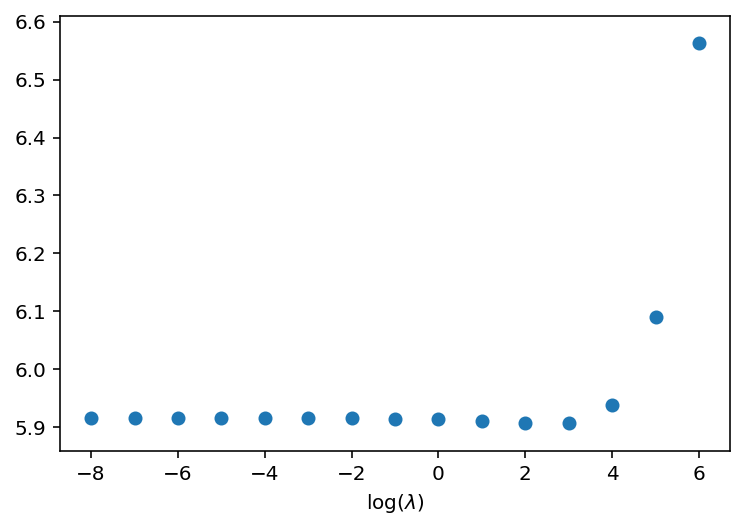

In [9]:
#Manually

alpha = np.exp(np.linspace(-8,6,15))

scores = np.zeros_like(alpha)

for i,a in enumerate(alpha):
    ridge = Ridge(alpha=a)
    cv_score = cross_val_score(ridge,transformed_X, ytrain, cv=10, scoring = 'neg_mean_squared_error')
    scores[i] = -cv_score.mean()
    
plt.scatter(np.log(alpha), scores)
plt.xlabel(r'$\log(\lambda)$')

Text(0.5, 0, '$\\log(\\lambda)$')

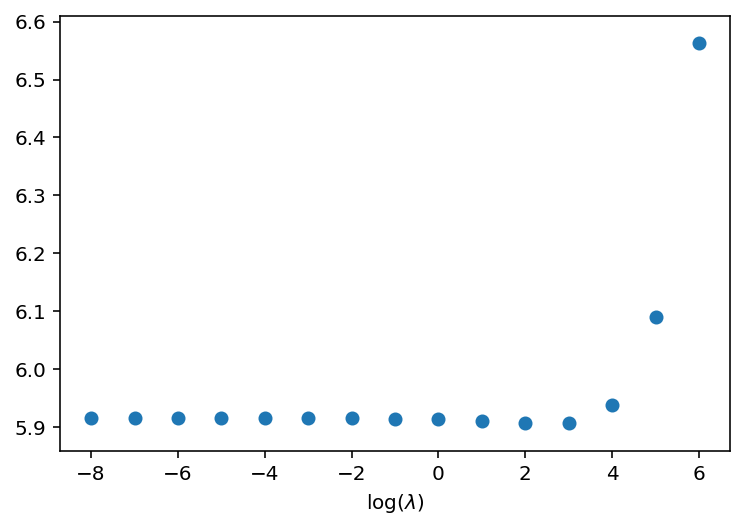

In [10]:
#With Pipelines
params = {'reg__alpha': np.exp(np.linspace(-8,6,15))}
gscv = GridSearchCV(model_pipeline, param_grid=params, cv=10, scoring = 'neg_mean_squared_error')
gscv.fit(Xtrain, ytrain)

results = pd.DataFrame(gscv.cv_results_)

plt.scatter( np.linspace(-8, 6,15), -results.mean_test_score)
plt.xlabel(r'$\log(\lambda)$')

Even give the reduced  amount of data, the model with 45 features is realtively simple. So, regularization does not reduce the variability of the model appreciably. So most of the error is bias.

### Question 6: Ridge regression with a more complex model - containing all 2-nd order interactions (2pt)
Give how well the model with all quadratic interactions worked the last time, your boss now wants to see if you can fit this model with all quadratic interaction terms to the data. 
Build a design matrix with all quadratic terms and 2-way interactions and then standardize them.  You can very easily do this by altering your pipeline.

Check how many regressors you have. Explain why you have this many terms. 

In [11]:
#Manually

scaler = StandardScaler()

poly_X = poly.fit_transform(Xtrain)
transformed_poly_X = scaler.fit_transform(poly_X)

transformed_poly_X.shape

(2500, 1224)

In [12]:
#With pipelines
poly_model_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('standardize', StandardScaler()),
    ('reg', Ridge(alpha=0.5)) ])




There are 49 columns in our design matrix.

Setting `degree=2` and `interactions_only=False` computes $x_i\cdot x_j$ for all $i,j=1, \cdots, 49$ and then adds this to our original design matrix. Note that when $i\neq j$, the ordering of the terms does not matter. This is a total of (49)(48)/2 + 49 + 49 = 1274 features.

If you are interested in knowing how I computed this, read the wikipedia page for "Triangular Number".

In [13]:
poly_model_pipeline.named_steps['poly'].fit_transform(Xtrain).shape

(2500, 1224)

### Question 7: Tune the Ridge coefficient for the 2nd-order model   (3pt)
Now use 10-fold CV on the training set to determine a good setting for the regularization coefficient. Perform the search in log-space, going from $\lambda = \exp(-8), \cdots, \exp(3)$ in steps of 15. Plot the mean squared error as a function of $log(\lambda)$. 

Written answer: What does the shape of the curve (as compared to the answer to Question 5) tell you about this model? What is the best regularization? 

Text(0.5, 0, '$\\log(\\lambda)$')

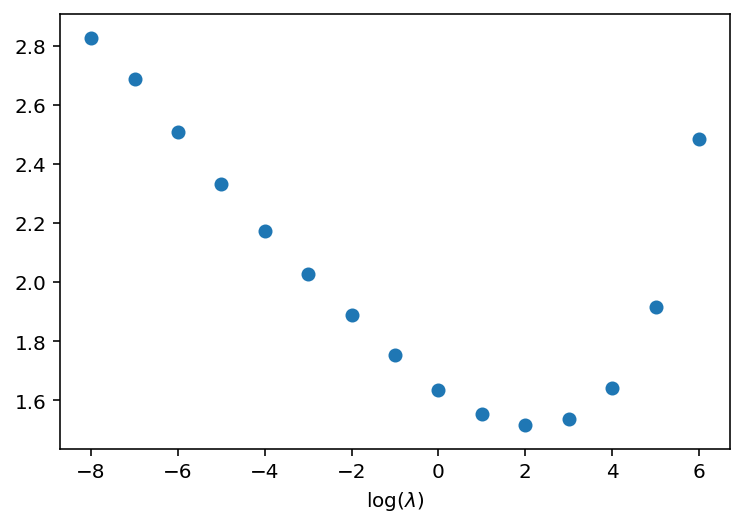

In [14]:
#Manually

for i,a in enumerate(alpha):
    ridge = Ridge(alpha=a)
    cv_score = cross_val_score(ridge,transformed_poly_X, ytrain, cv=10, scoring = 'neg_mean_squared_error')
    scores[i] = -cv_score.mean()
    
plt.scatter(np.log(alpha), scores)
plt.xlabel(r'$\log(\lambda)$')

Text(0.5, 0, '$\\log(\\lambda)$')

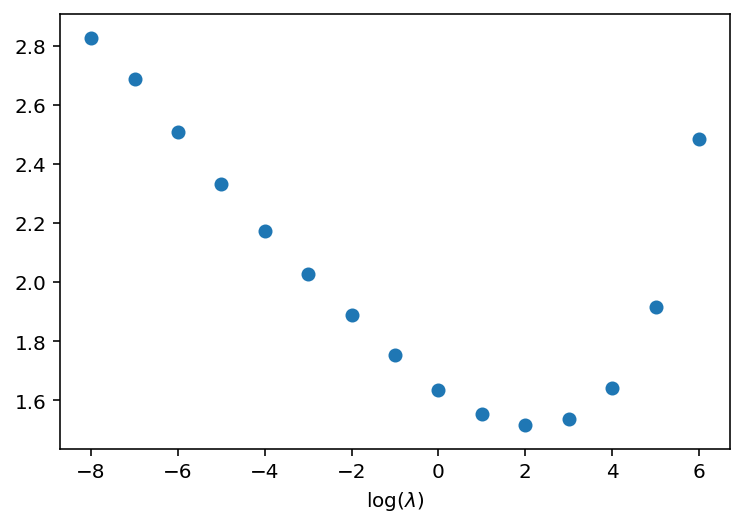

In [16]:
#With Pipelines
params = {'reg__alpha': np.exp(np.linspace(-8,6,15))}
gscv = GridSearchCV(poly_model_pipeline, param_grid=params, cv=10, scoring = 'neg_mean_squared_error', refit=True)
gscv.fit(Xtrain, ytrain)

results = pd.DataFrame(gscv.cv_results_)

plt.scatter( np.linspace(-8, 6,15), -results.mean_test_score)
plt.xlabel(r'$\log(\lambda)$')

Now the model is best with much more regularization -as compared to question 5. That means that most of the CV error comes from variance, rather than bias. The best lambda can be found using `gscv.best_params_`. 

### Question 8: Test error  (2pt)
Report proportion of variance predicted + the 95% confidence for the 2nd-order model with the best regularization parameter, when you fit it on the entire training set. 




In [17]:
# Manually
poly_Xtest = poly.transform(Xtest)
poly_transformed_Xtest = scaler.transform(poly_Xtest)

#Set alpha equal to the parameter which minimized cv score
ridge = Ridge(alpha=alpha[np.argmin(scores)])
ridge.fit(transformed_poly_X, ytrain)


yp = ridge.predict(poly_transformed_Xtest)

sqerr = (ytest-yp)**2 
ss = (ytest-ytest.mean())**2 
test_error = 1-sqerr.mean()/ss.mean() 
test_ci = test_error + 1.96 * np.std(sqerr) / np.sqrt(len(sqerr)) * np.array([-1, 1])
test_ci = 1-test_ci/ss.mean()
print("Mean variance predicted: ",test_error)
print("95% CI: ",test_ci)


print("Proportion variance predicted: ",1-test_error/ss.mean())



Mean variance predicted:  0.966904212584222
95% CI:  [0.98752421 0.97495498]
Proportion variance predicted:  0.9812395922277686


In [18]:
# With Pipelines
yp = gscv.predict(Xtest)

sqerr = (ytest-yp)**2 
ss = (ytest-ytest.mean())**2 
test_error = 1-sqerr.mean()/ss.mean() 
test_ci = test_error + 1.96 * np.std(sqerr) / np.sqrt(len(sqerr)) * np.array([-1, 1])
test_ci = 1-test_ci/ss.mean()
print("Mean variance predicted: ",test_error)
print("95% CI: ",test_ci)


print("Proportion variance predicted: ",1-test_error/ss.mean())



Mean variance predicted:  0.966904212584222
95% CI:  [0.98752421 0.97495498]
Proportion variance predicted:  0.9812395922277686


### Question 9: Fine-tuning (2 pt)
That's pretty impressive! 

Now, your boss thinks that you could slightly improve your test error by fine-tuning your ridge parameter on the test set for the full model fit. Your boss instructs you to combine the training and test sets, refit the model, and then re-test on the test set.

Would you predict that a smaller or bigger regularization factor would do better? What do you think of this procedure? Is this a reliable procedure for assessing model fit?  Answer in no more than 5 sentences.

The average size of the regularization parameter should not change, as the optimal parameter is just the variance of the noise / variance of the true effects. More data just leads to the regularization having less of an impact. However, given the particulars of the test set, a different ridge parameter maybe better for the test set. However, determining that optimal parameter on the test set would be a **bad** idea, as we would now systematically underestimate our generalization error.   